# Performance Evaluation

Informally evaluate OCT boundary estimation algorithms using the data set provided by [tia16].  

Note that we do *not* attempt any direct performance comparisons since the algorithms presented in the original paper did not have the benefit of training on this data set.  Results produced below provide some indication that our approach is reasonable; not necessarily that it is superior.


### References
- [tia16] Tian et al. Performance evaluation of automated segmentation software on optical coherence tomography volume data. J. Biophotonics, 2016.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys, time, glob

import pandas as pd

import numpy as np
import pylab as plt
from scipy.io import loadmat, savemat

import postproc_oct as poct

from IPython.display import display

print('Evaluated on:', time.strftime('%X %x %Z'))

Evaluated on: 12:03:31 10/07/17 EDT


# Functions/Structures for OCT Data


In [2]:
def tian_load_data(mat_file):
    """ Loads (a subset of the) data set from [tia16]. 
    
    Each patient has 5 images: one from fovea, 2 from para, and 2 from peri.
    These images appear to be ordered consecutively by patient (i.e. the
    first five images are for the first patient, the next 5 the second, etc.)
    
    However, it is not immediately obvious that the fovea/peri/para follow
    the same order within each patient.  There are some follow-on data 
    structures (see later in this cell) to help with this.
    """
    mf = loadmat(mat_file)
    all_algos = ['Spectralis', 'IOWA', 'Bern', 'AURA', 'OCTRIMA']
    print(mf.keys())
    
    # these functions map from original dimension ordering to something we prefer in python
    shuffle_algo = lambda x: np.transpose(x, [1,2,0])
    shuffle_miami = lambda x: np.transpose(x, [2,0,1])
    
    # Data and ground truth
    X =  shuffle_miami(mf['volumedata'])
    Y1 = shuffle_miami(mf['O1'])
    Y2 = shuffle_miami(mf['O2'])
    
    #---------------------------------------------------
    # Identify which subset of columns to evaluate
    #---------------------------------------------------
    mask = np.ones(Y1.shape[-1], dtype=np.bool)
    for algo in all_algos:
        Y_algo = shuffle_algo(mf[algo])
        is_valid = np.all(np.all(Y_algo >0, axis=0) >0, axis=0)
        mask = np.logical_and(mask, is_valid)
        
    print('feasibility mask admits %d columns' % np.sum(mask))
    plt.figure(); plt.plot(mask); plt.title('evaluation mask'); plt.ylim([-.01, 1.1]); plt.show()
           
    #---------------------------------------------------
    # Note that the number of surface annotations in O1/O2 is 9.
    # Table 2 in [tia16] lists 11 possible surfaces, so here
    # we determine which subset of O1/O2 has the 5 surfaces used
    # in the study.
    #---------------------------------------------------
    print('\nGround Truth Availability:')
    print('-'*80)
    for b_id in range(mf['O1'].shape[0]):
        y1 = mf['O1'][b_id,...]
        y2 = mf['O2'][b_id,...]
        print('boundary %d, O1/O2 median value:   %0.03f / %0.03f' % (b_id, np.median(y1.flatten()), np.median(y2.flatten())))
    print('-'*80 + '\n')
    
    boundaries_of_interest = np.array([0, 1, 2, 4, 7])  # via analysis above
    Y1 = Y1[:, boundaries_of_interest, :]
    Y2 = Y2[:, boundaries_of_interest, :]
    
    out = {}
    out['mask'] = mask
    out['X'] = X
    out['Y_O1'] = Y1
    out['Y_O2'] = Y2
    
    for algo in all_algos:
        out[algo] = shuffle_algo(mf[algo])
        #out[algo] = out[algo][..., mask]
    
    print('OCT images have shape: ', out['X'].shape)
    print('Truth has shape:       ', out['Y_O1'].shape)
    
    return out


def calc_err(tian, Y_hat):
    assert(all(Y_hat.shape) == tian['YO1'].shape)
    raise RuntimeError('todo')


# Here we map image indices to patient ids.
# Patient images seem to be consecutive (makes sense)
#
IMAGE_TO_PATIENT = { ii : np.floor(ii/5).astype(np.int32) for ii in range(50)}

# This data structure maps images to regions.
# These mappings do not appear to be stored in the matlab data structure, and were
# estimated by our domain experts.
# 
# Ref: Phil's email on august 17, 2017
#
FO = 'fovea'
PA = 'parafovea'
PE = 'perifovea'
IMAGE_TO_REGION = { 1 : FO,
                    2 : PA,
                    3 : PA,
                    4 : PE,
                    5 : PE,
                    6 : PE,
                    7 : PE,
                    8 : PA,
                    9 : PA,
                   10 : FO,
                   11 : PE, 
                   12 : PA, 
                   13 : FO,
                   14 : PA,
                   15 : PE, 
                   16 : PE,
                   17 : PA,
                   18 : FO,
                   19 : PA,
                   20 : PE,
                   21 : PE,
                   22 : PA,
                   23 : FO,
                   24 : PA,
                   25 : PE,
                   26 : PE,
                   27 : PA,
                   28 : FO,
                   29 : PA,
                   30 : PE,
                   31 : PA,
                   32 : FO,
                   33 : PA,
                   34 : PE,
                   35 : PE,
                   36 : PE,
                   37 : PA,
                   38 : FO,
                   39 : PA,
                   40 : PE,
                   41 : PA,
                   42 : FO,
                   43 : PA,
                   44 : PE,
                   45 : PE,
                   46 : PE,
                   47 : PA,
                   48 : FO,
                   49 : PA,
                   50 : PE}

# convert from numbering in email to 0-based idexing
IMAGE_TO_REGION = { x-1 : IMAGE_TO_REGION[x]  for x in IMAGE_TO_REGION.keys() }

print(IMAGE_TO_REGION)
print('')
print(IMAGE_TO_PATIENT)




{0: 'fovea', 1: 'parafovea', 2: 'parafovea', 3: 'perifovea', 4: 'perifovea', 5: 'perifovea', 6: 'perifovea', 7: 'parafovea', 8: 'parafovea', 9: 'fovea', 10: 'perifovea', 11: 'parafovea', 12: 'fovea', 13: 'parafovea', 14: 'perifovea', 15: 'perifovea', 16: 'parafovea', 17: 'fovea', 18: 'parafovea', 19: 'perifovea', 20: 'perifovea', 21: 'parafovea', 22: 'fovea', 23: 'parafovea', 24: 'perifovea', 25: 'perifovea', 26: 'parafovea', 27: 'fovea', 28: 'parafovea', 29: 'perifovea', 30: 'parafovea', 31: 'fovea', 32: 'parafovea', 33: 'perifovea', 34: 'perifovea', 35: 'perifovea', 36: 'parafovea', 37: 'fovea', 38: 'parafovea', 39: 'perifovea', 40: 'parafovea', 41: 'fovea', 42: 'parafovea', 43: 'perifovea', 44: 'perifovea', 45: 'perifovea', 46: 'parafovea', 47: 'fovea', 48: 'parafovea', 49: 'perifovea'}

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3, 20: 4, 21: 4, 22: 4, 23: 4, 24: 4, 25: 5, 26: 5, 27: 5, 28: 5, 29: 

# Load Data

dict_keys(['O1', 'O2', '__header__', 'Bern', 'IOWA', 'OCTRIMA', '__version__', 'Spectralis', 'volumedata', 'AURA', '__globals__'])
feasibility mask admits 442 columns


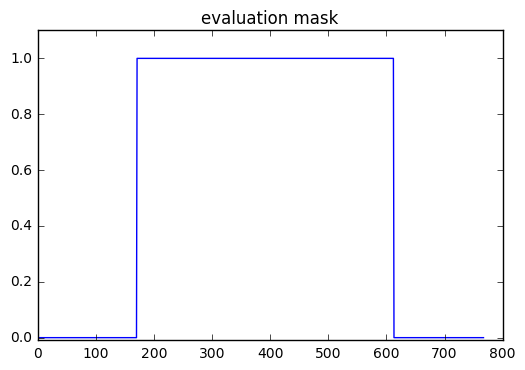


Ground Truth Availability:
--------------------------------------------------------------------------------
boundary 0, O1/O2 median value:   209.137 / 209.108
boundary 1, O1/O2 median value:   225.038 / 225.977
boundary 2, O1/O2 median value:   241.173 / 240.922
boundary 3, O1/O2 median value:   0.000 / 0.000
boundary 4, O1/O2 median value:   252.647 / 253.177
boundary 5, O1/O2 median value:   0.000 / 0.000
boundary 6, O1/O2 median value:   0.000 / 0.000
boundary 7, O1/O2 median value:   286.368 / 287.199
boundary 8, O1/O2 median value:   0.000 / 0.000
--------------------------------------------------------------------------------

OCT images have shape:  (50, 496, 768)
Truth has shape:        (50, 5, 768)
(50, 496, 768)
dict_keys(['AURA', 'X', 'IOWA', 'Y_O1', 'Y_O2', 'mask', 'Spectralis', 'Bern', 'OCTRIMA'])


In [3]:
#
# Load the data, ground truth, and OCT estimates from [tia16]
#
# NOTE: in section 3.3 of [tia16] the authors specify:
#   "Smaller unsigned error indicates the training data is closer to our
#    testing ground truth created by the Observer 1"
# Therefore, we use Y_O1 as ground truth in the remainder.
#
tian_fn = '/Users/pekalmj1/Data/Tian_OCT/jbio201500239-sup-0003-Data-S1.mat'

tian = tian_load_data(tian_fn)

print(tian['X'].shape)
print(tian.keys())

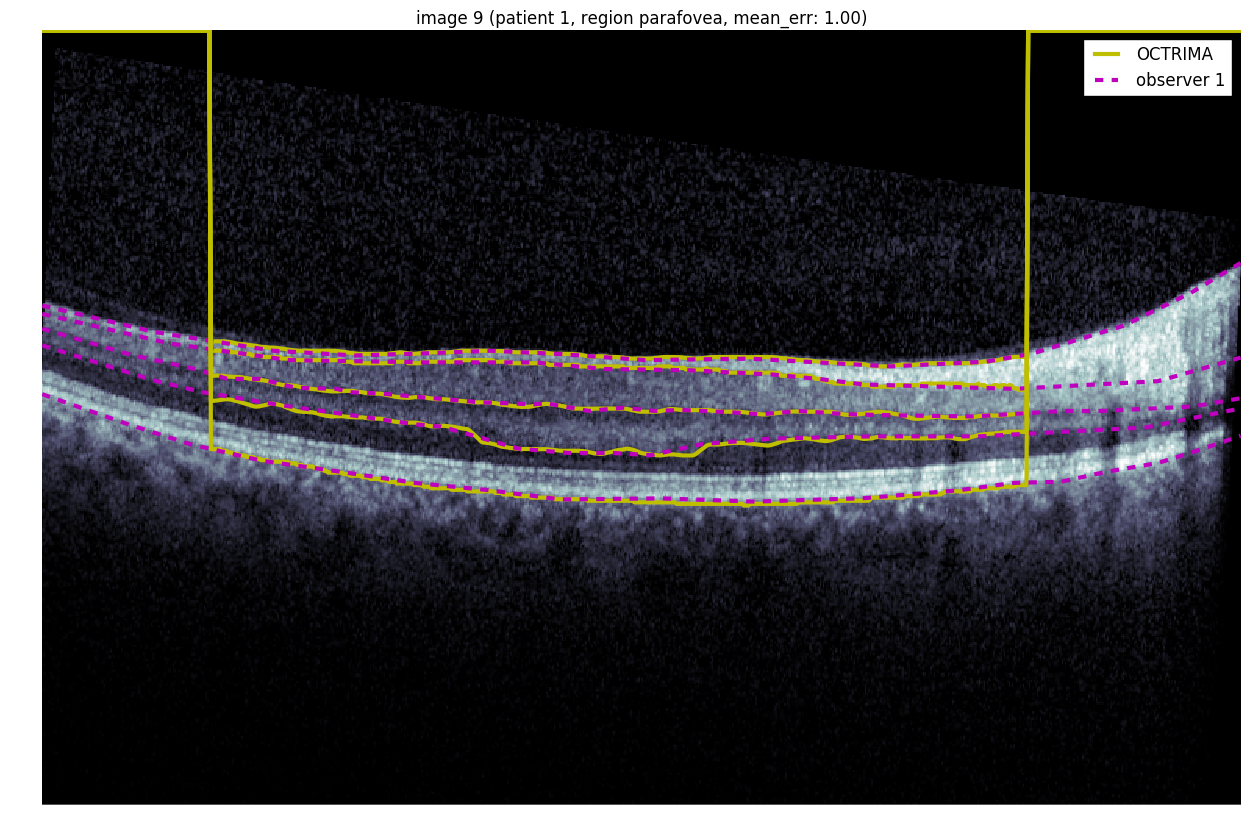

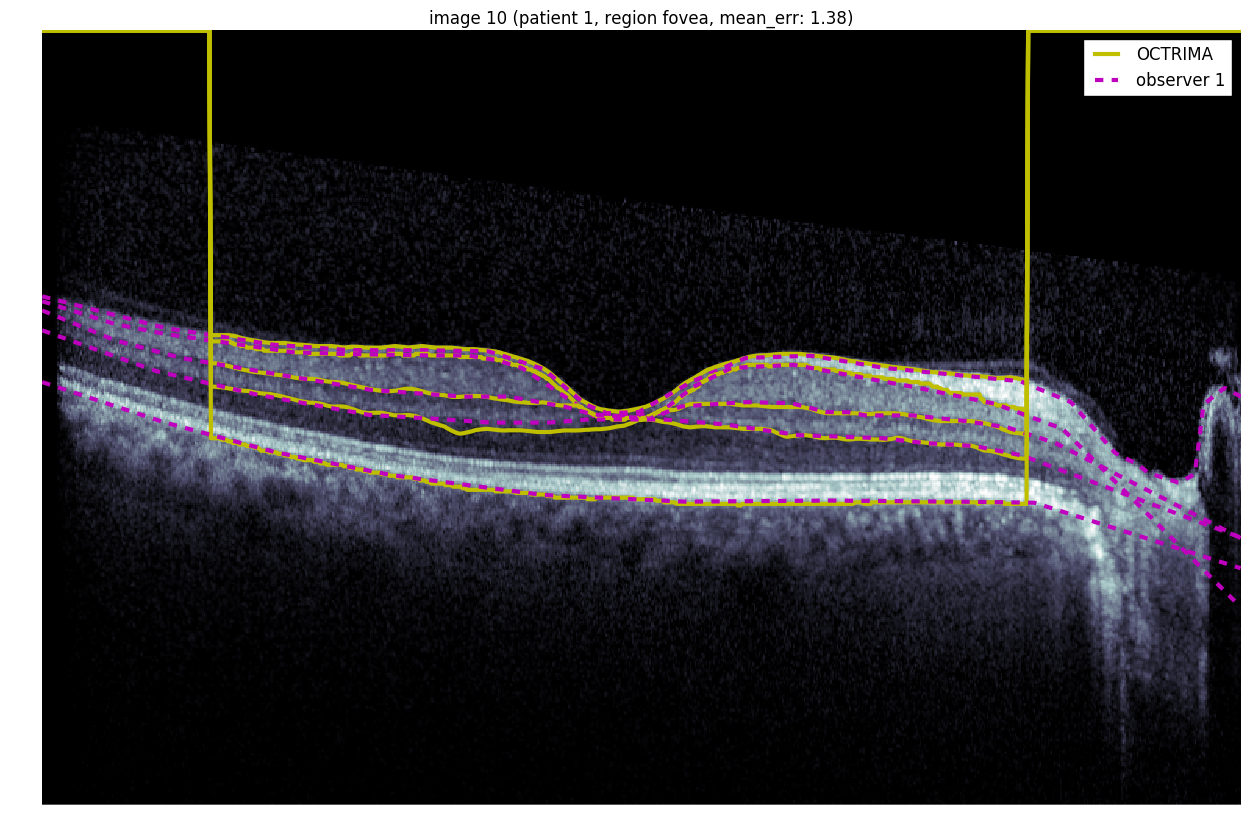

In [4]:
#------------------------------------------
# Visually inspect a subset of the data
#------------------------------------------
#which_algo = 'AURA'
which_algo = "OCTRIMA"

X = tian['X']
Y_true = tian['Y_O1']
Y_ref = tian[which_algo]


for img_idx in [8, 9]:
    plt.figure(figsize=(20,10))
    plt.imshow(X[img_idx,...], interpolation='none', cmap='bone')
    
    err = Y_true[img_idx, :, tian['mask']] - Y_ref[img_idx, :, tian['mask']]  # signed, per-pixel error
    mean_err = np.mean(np.abs(err)) 
    
    x_vals = np.arange(Y_true.shape[-1])

    for boundary_id in range(Y_true.shape[1]):
        plt.plot(x_vals, Y_ref[img_idx, boundary_id, :], '-y', linewidth=3, label=which_algo)
        plt.plot(x_vals, Y_true[img_idx, boundary_id, :], '--m', linewidth=3, label='observer 1')
        if boundary_id == 0: 
            plt.legend()

    plt.axis('off')
    plt.xlim([0, np.max(x_vals)])
    plt.ylim([0, X.shape[1]])
    plt.gca().invert_yaxis()
    
    
    plt.savefig('sample-annotations.eps', bbox_inches='tight')
    plt.title('image %d (patient %d, region %s, mean_err: %0.2f)' % (img_idx+1, IMAGE_TO_PATIENT[img_idx], IMAGE_TO_REGION[img_idx], mean_err))
    

(50, 512, 768)


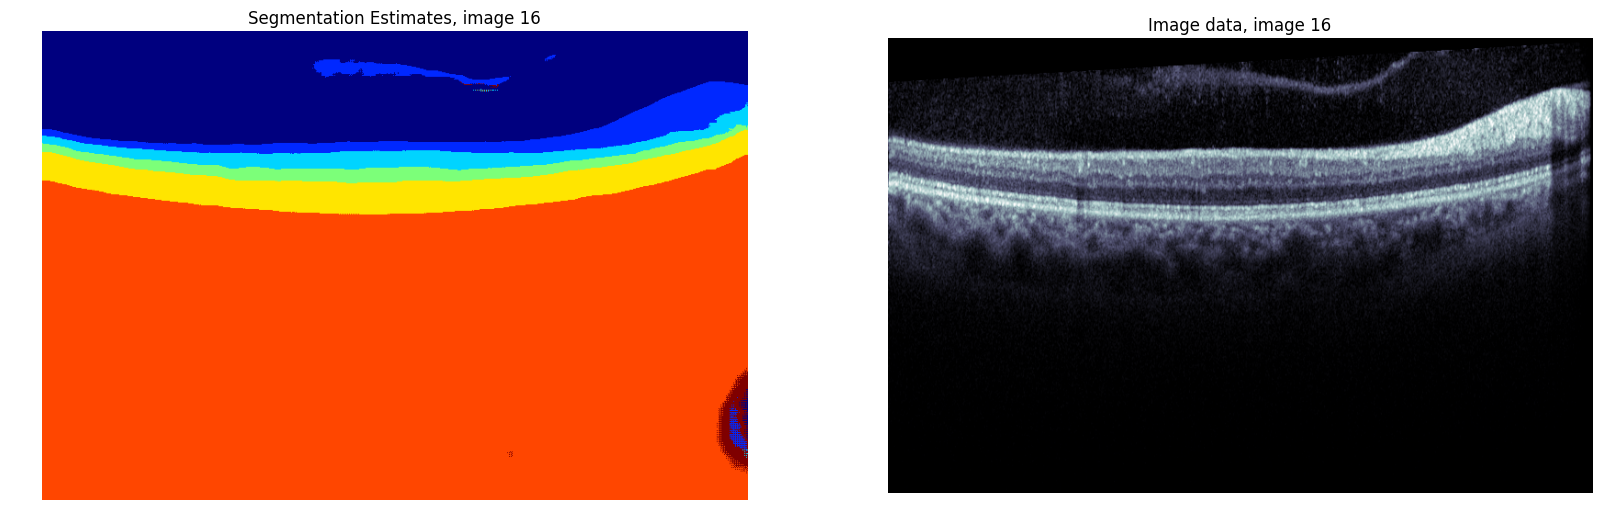

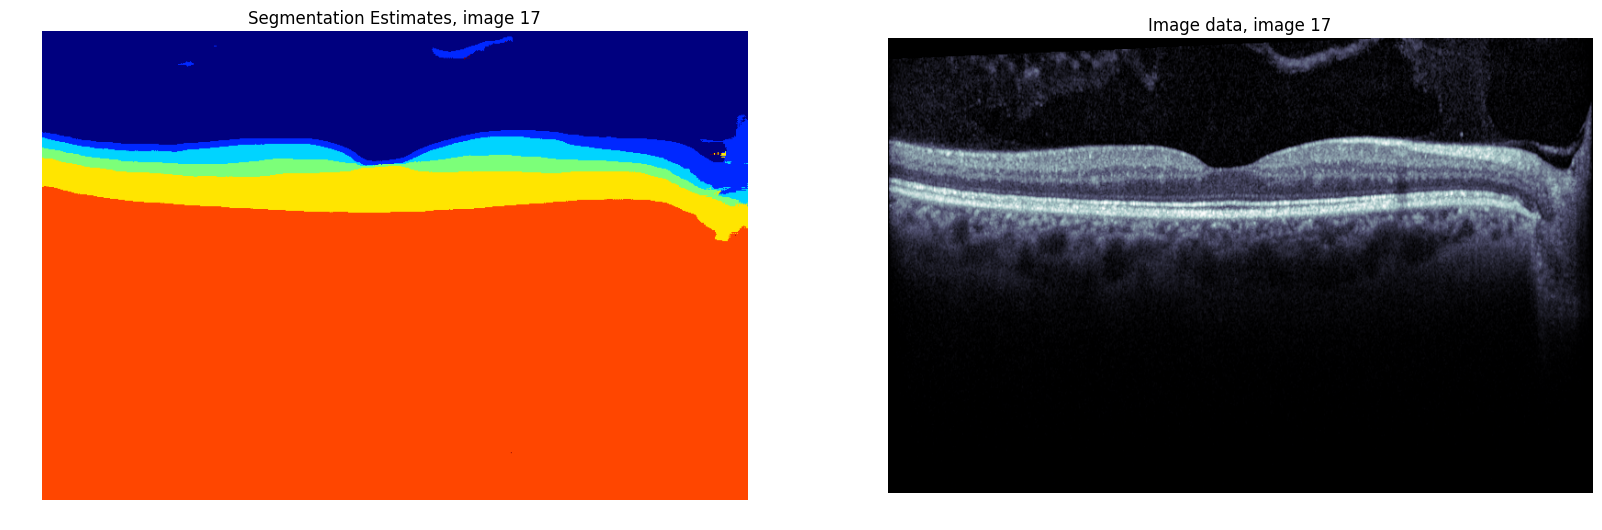

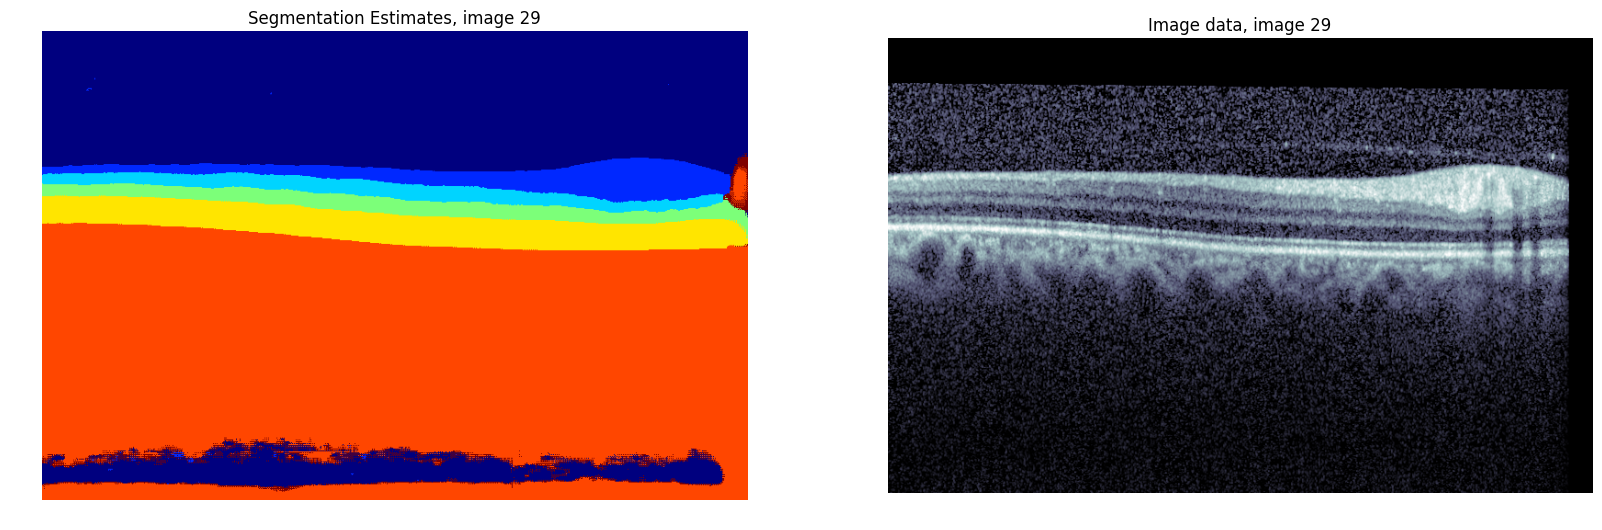

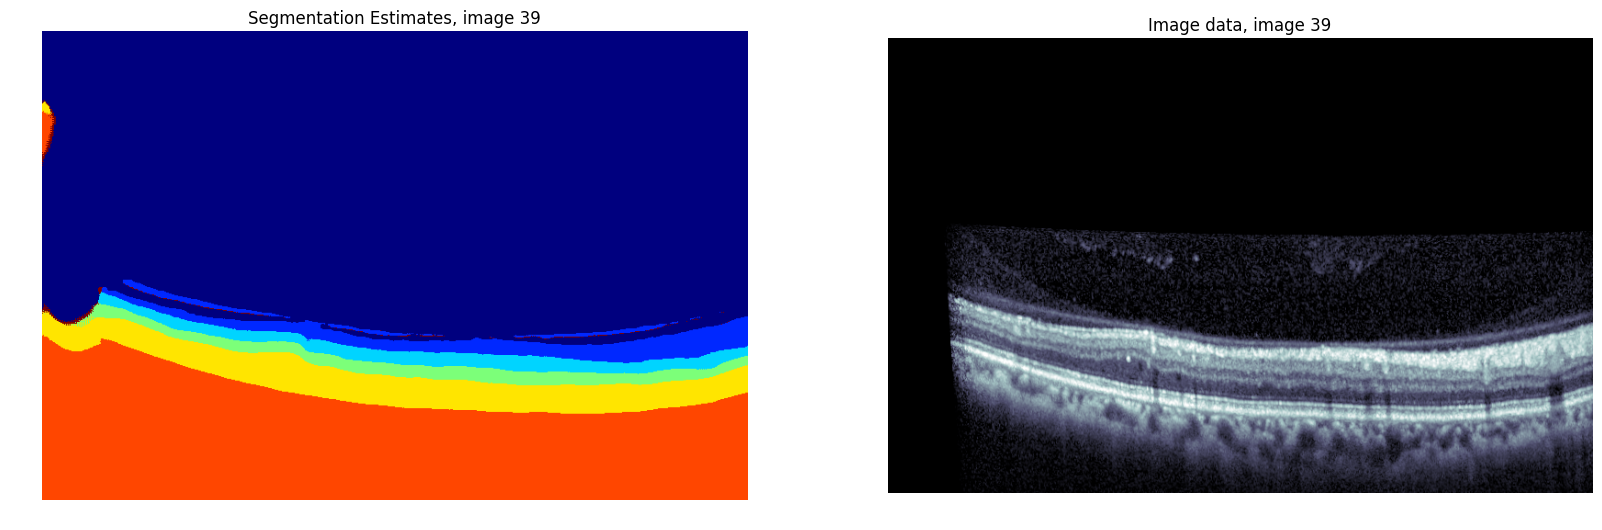

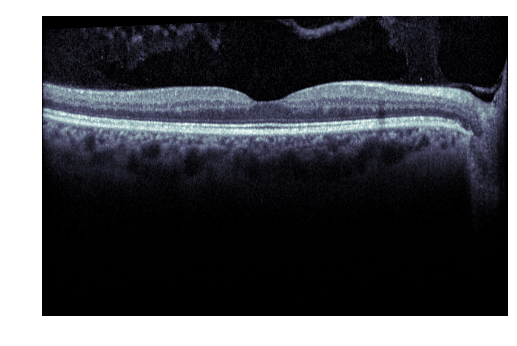

In [5]:
#----------------------------------------
# Load the raw segmentation estimates
#----------------------------------------

data_dir = './DenseNetFCN_Y_ensemble_results_kfold'
fold_files = glob.glob(os.path.join(data_dir, '*npz'))
fold_files.sort()  # use lexigraphic ordering to keep images/patients in order
y_hat_all = []
for fn in fold_files:
    y_hat_all.append(np.load(fn)['Y_hat_ensemble_mean'])
    
Y_hat_CNN = np.concatenate(y_hat_all, axis=0)
print(Y_hat_CNN.shape)


#----------------------------------------
# Visualize
#----------------------------------------
for img_idx in [16, 17, 29, 39]:
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(Y_hat_CNN[img_idx,:,:], interpolation=None)
    plt.axis('off')
    plt.title('Segmentation Estimates, image %d' % img_idx)
    #
    plt.subplot(1,2,2)
    plt.imshow(tian['X'][img_idx,...], interpolation=None, cmap='bone')
    plt.axis('off')
    plt.title('Image data, image %d' % img_idx)
plt.show()

# make figures for paper
for img_idx in [17]:
    plt.figure()
    plt.imshow(Y_hat_CNN[img_idx,:,:], interpolation=None)
    plt.axis('off')
    plt.savefig('raw_segmentation_%02d.eps' % img_idx, bbox_inches='tight')    
    #
    plt.imshow(tian['X'][img_idx,...], interpolation=None, cmap='bone')
    plt.axis('off')
    plt.savefig('oct_image_%02d.eps' % img_idx, bbox_inches='tight')

In [6]:
#----------------------------------------
# Generate explicit boundary estimates
#----------------------------------------

n_images = Y_hat_CNN.shape[0]

# we use NaN as a default value (rather than 0) so that,
# when we compute means, we can effectively ignore missing data 
# (ie. images we haven't processed yet).
surf_est_raw = np.nan * np.ones(tian['Y_O1'].shape)   # raw CNN estimates
surf_est_int = np.nan * np.ones(tian['Y_O1'].shape)   # interpolated estimates

# These are the columns for which we desire estimates
# (subset of data for which 3rd party estimates are available)
eval_cols = np.sort(np.nonzero(tian['mask'])[0])


for img_idx in range(n_images):
    print('Processing image %d (of %d)' % (img_idx, n_images)) 
    
    # special case processing for boundary 0 (we have more noise in that class estimate...)
    rows1, cols1 = poct.get_class_transitions(Y_hat_CNN[img_idx, :, :], 1, dedup=True)
    rows0, cols0 = poct.get_class_transitions(Y_hat_CNN[img_idx, :, :], 0, dedup=False)
    cols0, rows0 = poct.deduplicate_nn(cols0, rows0, cols1, rows1)
    surf_est_raw[img_idx, 0, cols0] = rows0
    surf_est_int[img_idx, 0, eval_cols] = np.squeeze(poct.boundary_regression_1d(cols0, rows0, eval_cols))
    
    # the other surfaces are a bit cleaner
    for b_id in range(1,5):
        rows, cols = poct.get_class_transitions(Y_hat_CNN[img_idx, :, :], b_id, dedup=True)  
        surf_est_raw[img_idx, b_id, cols] = rows
        surf_est_int[img_idx, b_id, eval_cols] = np.squeeze(poct.boundary_regression_1d(cols, rows, eval_cols))
    

#------------------------------    
# Visualize    
#------------------------------
for img_idx in range(n_images):
    
    # for now, we just want to look at images with issues in surface 0
    y_hat_raw_0 = surf_est_raw[img_idx,0,eval_cols]
    y_hat_int_0 = surf_est_int[img_idx,0,eval_cols]
    y_true_0 = tian['Y_O1'][img_idx,0,eval_cols]
    
    err = np.nanmean(np.abs(y_hat_raw_0 - y_true_0))
    if err <= 2:
        continue
    
    plt.figure(figsize=(20,10))
    plt.imshow(tian['X'][img_idx,...], interpolation='none', cmap='bone')
    for b_id in range(5):
        plt.plot(surf_est_raw[img_idx,b_id,:], 'c-')
        plt.plot(surf_est_int[img_idx,b_id,:], 'b-')
        plt.plot(tian['Y_O1'][img_idx,b_id,:], 'm--')
    plt.xlim([0, tian['X'].shape[-1]])
    plt.ylim([0, tian['X'].shape[-2]])
    plt.gca().invert_yaxis()
    plt.title('image %d (s0 error: %0.3f)' % (img_idx, err))
    
    plt.show()


Processing image 0 (of 50)
Processing image 1 (of 50)
Processing image 2 (of 50)
Processing image 3 (of 50)
Processing image 4 (of 50)
Processing image 5 (of 50)
Processing image 6 (of 50)
Processing image 7 (of 50)
Processing image 8 (of 50)
Processing image 9 (of 50)
Processing image 10 (of 50)
Processing image 11 (of 50)
Processing image 12 (of 50)
Processing image 13 (of 50)
Processing image 14 (of 50)
Processing image 15 (of 50)
Processing image 16 (of 50)
Processing image 17 (of 50)
Processing image 18 (of 50)
Processing image 19 (of 50)
Processing image 20 (of 50)
Processing image 21 (of 50)
Processing image 22 (of 50)
Processing image 23 (of 50)
Processing image 24 (of 50)
Processing image 25 (of 50)
Processing image 26 (of 50)
Processing image 27 (of 50)
Processing image 28 (of 50)
Processing image 29 (of 50)
Processing image 30 (of 50)
Processing image 31 (of 50)
Processing image 32 (of 50)
Processing image 33 (of 50)
Processing image 34 (of 50)
Processing image 35 (of 50)
Pr

In [7]:
# It is not a fair evaluation to allow the surf_est_raw to have NaN values within the evaluation window.
# Therefore, we apply a simple heuristic to fill in any missing values

for img_idx in range(surf_est_raw.shape[0]):
    for b_idx in range(surf_est_raw.shape[1]):
        is_missing = np.nonzero(np.isnan(surf_est_raw[img_idx, b_idx, :]))[0]
        
        if len(is_missing):
            # grab the nearest non-missing pixel as a replacement
            is_present = np.nonzero(~np.isnan(surf_est_raw[img_idx, b_idx, :]))[0]
            nearest_present = [is_present[np.argmin(np.abs(x - is_present))] for x in is_missing]
            #print(np.c_[is_missing, nearest_present].transpose())
            surf_est_raw[img_idx, b_idx, is_missing] = surf_est_raw[img_idx, b_idx, nearest_present]
            
            
# These should both be zero
print(np.sum(np.isnan(surf_est_raw[:,:,eval_cols])))
print(np.sum(np.isnan(surf_est_int[:,:,eval_cols])))

savemat('apl_estimates.mat', {'seg' : surf_est_raw, 'reg' : surf_est_int})

0
0


# Error Analysis

## Per-region errors
Examine surface estimation errors for various regions of the eye.

In [22]:
def mean_error(Y_true, Y_other, surface_id, region_id):
    """Computes boundary estimation error (in pixels).
    As was done in table 5 of [tia16] we compute these errors on a per-surface basis.
    """
    n_images = Y_true.shape[0]
    
    if region_id is not None:
        which_images = [x for x in range(n_images) if region_id == IMAGE_TO_REGION[x]]    
    else:
        which_images = np.arange(n_images)

    err = Y_true[which_images, surface_id, :] - Y_other[which_images, surface_id, :]
    
    # compute mean signed (mu_s) and unsigned (mu_u) errors
    # Note that unevaluated pixels will be NaN, hence nanmean
    mu_s = np.nanmean(err)
    mu_u = np.nanmean(np.abs(err))
    return mu_u, mu_s
       
    
# just to simplify subsequent code, add our estimates to the overall collection from Tian et al.
tian['SEG'] = surf_est_raw
tian['SEG+REG'] = surf_est_int
tian['Inter-Observer'] = tian['Y_O2']

# this is to align our surface ids with those of [tian]
surf_map = [1,2,4,6,11]

# determine which pixels and algorithms to evaluate
eval_cols = np.sort(np.nonzero(tian['mask'])[0])
eval_algos = ['SEG', 'SEG+REG', 'Spectralis', 'OCTRIMA', 'AURA', 'IOWA', 'Bern', 'Inter-Observer']

rows = []
Errors_u = np.zeros((5*3, len(eval_algos)))
Errors_s = np.zeros((5*3, len(eval_algos)))
Errors_per_surface_u = np.zeros((5, len(eval_algos)))
Errors_per_surface_s = np.zeros((5, len(eval_algos)))

for surface in np.arange(5):
    #-----------------------------------------------
    # per-surface error (aggregated across all regions)
    #-----------------------------------------------
    for algo_idx, algo in enumerate(eval_algos):
        err_u, err_s = mean_error(tian['Y_O1'][..., eval_cols],
                                  tian[algo][..., eval_cols],
                                  surface, region_id=None)
        Errors_per_surface_u[surface, algo_idx] = err_u
        Errors_per_surface_s[surface, algo_idx] = err_s
        
    #-----------------------------------------------
    # per-region errors
    #-----------------------------------------------
    for region in [FO, PA, PE]:
        rows.append('surface%d %s' % (surf_map[surface], region))
              
        for algo_idx, algo in enumerate(eval_algos):
            err_u, err_s = mean_error(tian['Y_O1'][..., eval_cols], 
                                      tian[algo][..., eval_cols], 
                                      surface, region)
            Errors_s[len(rows)-1, algo_idx] = err_s
            Errors_u[len(rows)-1, algo_idx] = err_u


with pd.option_context('display.max_columns', 10, 'precision', 2):
    df = pd.DataFrame(data=Errors_u, index=rows, columns=eval_algos)
    print('Mean unsigned error (per-region):')
    display(df)
    table1 = df.to_latex()
    
    df = pd.DataFrame(data=Errors_s, index=rows, columns=eval_algos)
    print('Mean signed error (per-region):')
    display(df)
    table2 = df.to_latex()
    
    df = pd.DataFrame(data=Errors_per_surface_u, index=['surface %d' % surf_map[x] for x in range(5)], columns=eval_algos)
    print('Mean unsigned error (per-surface):')
    display(df)
    table3 = df.to_latex()
    
    df = pd.DataFrame(data=Errors_per_surface_s, index=['surface %d' % surf_map[x] for x in range(5)], columns=eval_algos)
    print('Mean signed error (per-surface):')
    display(df)
    table4 = df.to_latex()

Mean unsigned error (per-region):


SEG  SEG+REG  Spectralis  OCTRIMA  AURA  IOWA  Bern  \
surface1 fovea       1.18     1.13        0.90     0.90  0.90  2.14  1.67   
surface1 parafovea   1.12     1.10        1.14     1.00  1.31  1.98  1.81   
surface1 perifovea   1.12     1.09        1.13     0.92  1.62  2.01  1.62   
surface2 fovea       1.34     1.24        1.39     1.15  1.29  2.42  2.02   
surface2 parafovea   1.03     0.97        0.92     1.03  0.92  1.59  2.45   
surface2 perifovea   1.15     1.05        2.02     1.35  1.42  1.54  3.47   
surface4 fovea       1.10     1.08        1.30     1.12  1.25  1.81  1.44   
surface4 parafovea   0.91     0.89        1.32     0.91  1.02  1.67  1.52   
surface4 perifovea   0.92     0.88        2.82     1.00  1.14  1.89  1.76   
surface6 fovea       1.45     1.40        1.79     2.75  2.58  1.58  1.86   
surface6 parafovea   1.26     1.22        1.10     1.36  1.42  1.50  1.74   
surface6 perifovea   1.08     1.04        0.99     1.08  1.14  1.49  1.62   
surface11 fovea      0.92     0.88        0.81     1.02  0.88  1.08  1.23   
surface11 parafovea  1.07     1.04        0.98     1.19  0.95  1.14  1.16   
surface11 perifovea  1.11     1.08        1.07     1.31  1.02  1.38  1.32   

                     Inter-Observer  
surface1 fovea                 0.85  
surface1 parafovea             0.89  
surface1 perifovea             0.86  
surface2 fovea                 1.31  
surface2 parafovea             0.97  
surface2 perifovea             1.22  
surface4 fovea                 1.13  
surface4 parafovea             1.08  
surface4 perifovea             1.11  
surface6 fovea                 1.50  
surface6 parafovea             1.36  
surface6 perifovea             1.11  
surface11 fovea                1.12  
surface11 parafovea            1.12  
surface11 perifovea            1.11

Mean signed error (per-region):


SEG  SEG+REG  Spectralis  OCTRIMA  AURA  IOWA  Bern  \
surface1 fovea       1.04     1.02       -0.49     0.74  0.76  2.13  1.64   
surface1 parafovea   0.87     0.88       -0.91     0.69  1.16  1.95  1.76   
surface1 perifovea   0.85     0.85       -0.89     0.59  1.51  1.96  1.55   
surface2 fovea      -0.42    -0.54        0.36     0.17  0.77  2.01  1.52   
surface2 parafovea  -0.37    -0.37        0.47     0.36  0.14  1.41  2.25   
surface2 perifovea   0.29     0.28        1.25    -0.04  0.33  1.25  3.31   
surface4 fovea       0.25     0.25        0.27    -0.30 -0.01  1.49  1.07   
surface4 parafovea   0.13     0.14        0.78    -0.02  0.25  1.46  1.22   
surface4 perifovea   0.18     0.19        2.67     0.46  0.78  1.77  1.51   
surface6 fovea      -0.55    -0.55       -1.39    -2.43 -2.12  0.19  0.25   
surface6 parafovea  -0.11    -0.11       -0.42    -0.83 -0.15  0.79  1.39   
surface6 perifovea  -0.37    -0.37       -0.15    -0.25 -0.06  1.07  1.30   
surface11 fovea     -0.49    -0.48       -0.34    -0.79 -0.62  0.91  0.93   
surface11 parafovea -0.73    -0.73       -0.47    -0.99 -0.62  0.96  0.82   
surface11 perifovea -0.68    -0.68       -0.46    -0.98 -0.52  1.20  0.96   

                     Inter-Observer  
surface1 fovea                 0.36  
surface1 parafovea             0.17  
surface1 perifovea             0.30  
surface2 fovea                 0.65  
surface2 parafovea             0.17  
surface2 perifovea             0.22  
surface4 fovea                 0.03  
surface4 parafovea             0.17  
surface4 perifovea             0.54  
surface6 fovea                -0.21  
surface6 parafovea             0.22  
surface6 perifovea             0.11  
surface11 fovea               -0.76  
surface11 parafovea           -0.82  
surface11 perifovea           -0.53

Mean unsigned error (per-surface):


SEG  SEG+REG  Spectralis  OCTRIMA  AURA  IOWA  Bern  \
surface 1   1.13     1.10        1.09     0.95  1.35  2.03  1.71   
surface 2   1.14     1.06        1.45     1.18  1.19  1.74  2.77   
surface 4   0.95     0.92        1.92     0.99  1.12  1.79  1.60   
surface 6   1.23     1.19        1.19     1.52  1.54  1.51  1.72   
surface 11  1.06     1.02        0.99     1.20  0.96  1.22  1.24   

            Inter-Observer  
surface 1             0.87  
surface 2             1.14  
surface 4             1.10  
surface 6             1.29  
surface 11            1.12

Mean signed error (per-surface):


SEG  SEG+REG  Spectralis  OCTRIMA  AURA  IOWA  Bern  \
surface 1   0.90     0.89       -0.82     0.66  1.22  1.99  1.65   
surface 2  -0.12    -0.14        0.76     0.16  0.34  1.47  2.53   
surface 4   0.18     0.18        1.43     0.12  0.41  1.59  1.30   
surface 6  -0.30    -0.30       -0.51    -0.92 -0.51  0.78  1.13   
surface 11 -0.66    -0.66       -0.44    -0.94 -0.58  1.04  0.90   

            Inter-Observer  
surface 1             0.26  
surface 2             0.29  
surface 4             0.29  
surface 6             0.09  
surface 11           -0.69

In [23]:
# show latex
print(table1)
print(table2)
print(table3)
print(table4)

\begin{tabular}{lrrrrrrrr}
\toprule
{} &   SEG &  SEG+REG &  Spectralis &  OCTRIMA &  AURA &  IOWA &  Bern &  Inter-Observer \\
\midrule
surface1 fovea      &  1.18 &     1.13 &        0.90 &     0.90 &  0.90 &  2.14 &  1.67 &            0.85 \\
surface1 parafovea  &  1.12 &     1.10 &        1.14 &     1.00 &  1.31 &  1.98 &  1.81 &            0.89 \\
surface1 perifovea  &  1.12 &     1.09 &        1.13 &     0.92 &  1.62 &  2.01 &  1.62 &            0.86 \\
surface2 fovea      &  1.34 &     1.24 &        1.39 &     1.15 &  1.29 &  2.42 &  2.02 &            1.31 \\
surface2 parafovea  &  1.03 &     0.97 &        0.92 &     1.03 &  0.92 &  1.59 &  2.45 &            0.97 \\
surface2 perifovea  &  1.15 &     1.05 &        2.02 &     1.35 &  1.42 &  1.54 &  3.47 &            1.22 \\
surface4 fovea      &  1.10 &     1.08 &        1.30 &     1.12 &  1.25 &  1.81 &  1.44 &            1.13 \\
surface4 parafovea  &  0.91 &     0.89 &        1.32 &     0.91 &  1.02 &  1.67 &  1.52 &           